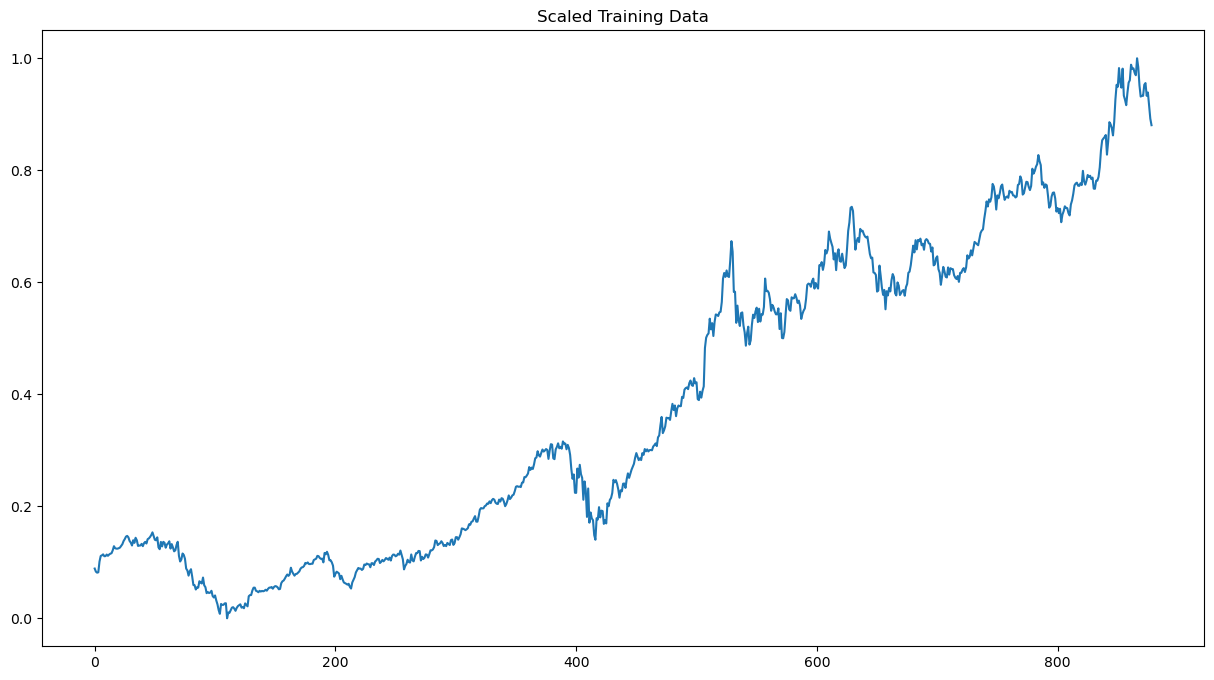

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout

# Load your data
data = pd.read_csv("C:\\Users\\lefen\\Downloads\\AAPL.csv")
# Convert the 'Date' column to a proper date format
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
# Extract the closing prices
data_set = data['Close'].values.reshape(-1, 1)
train = data_set[:len(data_set) - 50]
test = data_set[len(data_set) - 50:]

# Split ratio (e.g., 80% for training and 20% for testing)
split_ratio = 0.7
split_index = int(len(data_set) * split_ratio)
# Train-test split
train = data_set[:split_index]
test = data_set[split_index:]
#scaling and preprocessing
scaler = MinMaxScaler(feature_range=(0,1))
train_scaler = scaler.fit_transform(train)
#Visualizing the scaled training data
plt.figure(figsize=[15,8])
plt.plot(train_scaler)
plt.title('Scaled Training Data')
plt.show()


In [26]:
# Create training data
X_train = []
Y_train = []
timesteps = 50

for i in range(timesteps, len(train_scaler)):
    X_train.append(train_scaler[i - timesteps:i, 0])
    Y_train.append(train_scaler[i, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Define and train the RNN model
regressor = Sequential()
regressor.add(SimpleRNN(units=50, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(SimpleRNN(units=50, activation="tanh", return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(SimpleRNN(units=50, activation="tanh", return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(SimpleRNN(units=50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))
regressor.compile(optimizer="adam", loss="mean_squared_error")
regressor.fit(X_train, Y_train, epochs=100, batch_size=32)

# Prepare the test inputs
inputs = data_set[len(data_set) - len(test) - timesteps:]
inputs = scaler.transform(inputs)
X_test = [inputs[i - timesteps:i, 0] for i in range(timesteps, inputs.shape[0])]
X_test_rnn = np.array(X_test)
X_test_rnn = np.reshape(X_test_rnn, (X_test_rnn.shape[0], X_test_rnn.shape[1], 1))

# Predict on test set
predicted_stock_price = regressor.predict(X_test_rnn)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

Epoch 1/100
26/26 [==============================] - 5s 23ms/step - loss: 0.3754
Epoch 2/100
26/26 [==============================] - 1s 24ms/step - loss: 0.2411
Epoch 3/100
26/26 [==============================] - 1s 22ms/step - loss: 0.1845
Epoch 4/100
26/26 [==============================] - 1s 21ms/step - loss: 0.1308
Epoch 5/100
26/26 [==============================] - 1s 21ms/step - loss: 0.1116
Epoch 6/100
26/26 [==============================] - 1s 46ms/step - loss: 0.0977
Epoch 7/100
26/26 [==============================] - 1s 23ms/step - loss: 0.0755
Epoch 8/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0584
Epoch 9/100
26/26 [==============================] - 1s 22ms/step - loss: 0.0549
Epoch 10/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0519
Epoch 11/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0444
Epoch 12/100
26/26 [==============================] - 1s 25ms/step - loss: 0.0320
Epoch 13/100
26/26 [=====

1/1 [==============================] - 0s 21ms/step


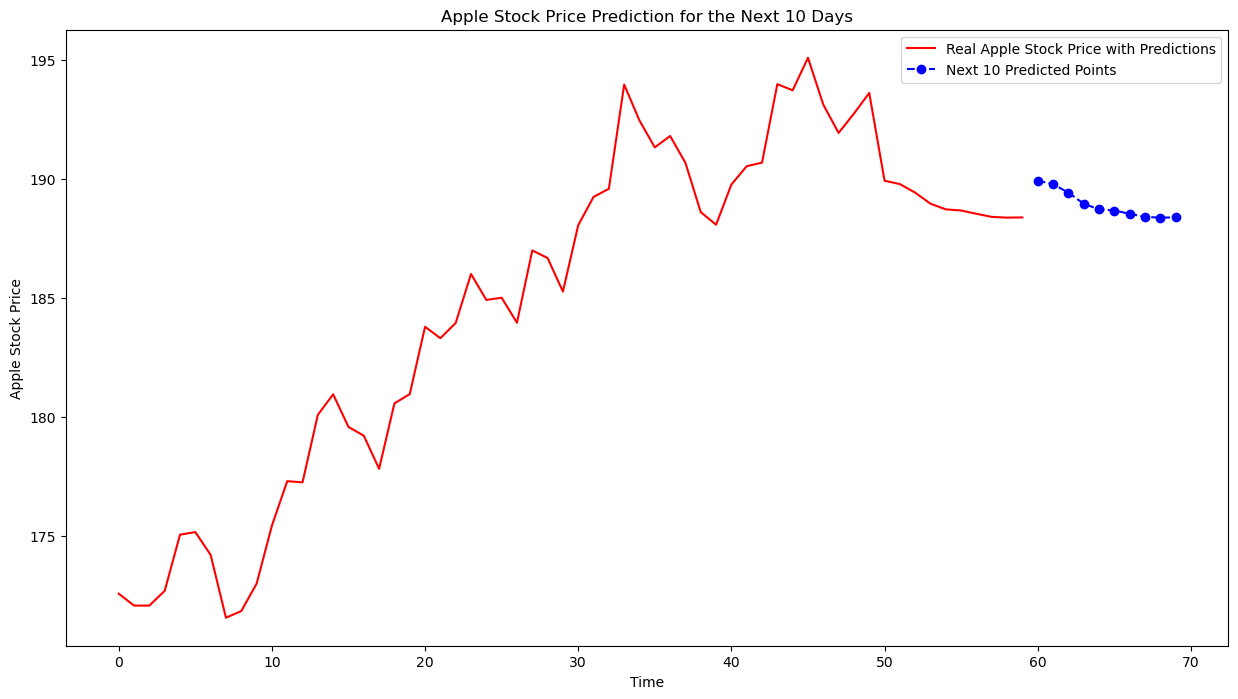

In [27]:
# Make 10 future predictions
predictions = []
for _ in range(10):
    last_50 = data_set[-timesteps:]
    last_50_scaled = scaler.transform(last_50)
    model_input = np.reshape(last_50_scaled, (1, timesteps, 1))
    predicted_value = regressor.predict(model_input)
    predicted_value_unscaled = scaler.inverse_transform(predicted_value)
    data_set = np.append(data_set, predicted_value_unscaled, axis=0)
    predictions.append(predicted_value_unscaled[0, 0])
predictions = np.array(predictions).reshape(-1, 1)

# Plot the results
plt.figure(figsize=(15, 8))
plt.plot(data_set[-60:], color="red", label="Real Apple Stock Price with Predictions")
plt.plot(np.arange(60, 70), predictions, color="blue", linestyle="--", marker="o", label="Next 10 Predicted Points")
plt.title("Apple Stock Price Prediction for the Next 10 Days")
plt.xlabel("Time")
plt.ylabel("Apple Stock Price")
plt.legend()
plt.show()

In [28]:
# Display the 10 predicted values
print("Predicted Apple Stock Prices for the Next 10 Days:")
for i, price in enumerate(predictions, 1):
    print(f"Day {i}: ${price[0]:.2f}")


Predicted Apple Stock Prices for the Next 10 Days:
Day 1: $189.93
Day 2: $189.79
Day 3: $189.43
Day 4: $188.96
Day 5: $188.73
Day 6: $188.68
Day 7: $188.54
Day 8: $188.41
Day 9: $188.38
Day 10: $188.39


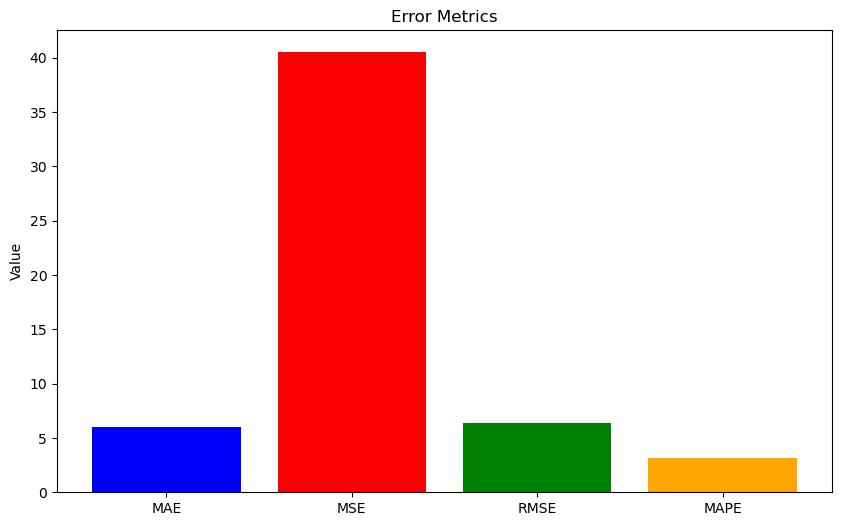

[5.983999999999997, 40.499659999999956, 6.363934317700015, 3.1757367048968685]

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Actual values
actual_values = [194.50, 193.22, 195.83, 196.45, 195.61, 192.58, 191.17, 181.99, 178.85, 179.80]

# Predicted values
predicted_values_list = [189.93, 189.79, 189.43, 188.96, 188.73, 188.68, 188.54, 188.41, 188.38, 188.39]

# Calculate MAE, MSE, and RMSE
MAE = mean_absolute_error(actual_values, predicted_values_list)
MSE = mean_squared_error(actual_values, predicted_values_list)
RMSE = np.sqrt(MSE)

# Calculate MAPE
MAPE = np.mean(np.abs((np.array(actual_values) - np.array(predicted_values_list)) / np.array(actual_values))) * 100

MAE, MSE, RMSE, MAPE
# Plotting the error metrics
error_metrics = [MAE, MSE, RMSE, MAPE]
labels = ['MAE', 'MSE', 'RMSE', 'MAPE']

plt.figure(figsize=(10, 6))
plt.bar(labels, error_metrics, color=['blue', 'red', 'green', 'orange'])
plt.title('Error Metrics')
plt.ylabel('Value')
plt.show()

error_metrics